In [2]:
import os

os.chdir('/content')
CODE_DIR = 'idinvert'
if not os.path.exists(CODE_DIR):
  !git clone https://github.com/MrLishu/idinvert_pytorch.git $CODE_DIR
os.chdir(f'./{CODE_DIR}')

MODEL_DIR = os.path.join('models', 'pretrain')
os.makedirs(MODEL_DIR, exist_ok=True)
!wget https://mycuhk-my.sharepoint.com/:u:/g/personal/1155082926_link_cuhk_edu_hk/EXqix_JIEgtLl1FXI4uCkr8B5GPaiJyiLXL6cFbdcIKqEA?e=WYesel\&download\=1 -O $MODEL_DIR/styleganinv_ffhq256_encoder.pth  --quiet
!wget https://mycuhk-my.sharepoint.com/:u:/g/personal/1155082926_link_cuhk_edu_hk/EbuzMQ3ZLl1AqvKJzeeBq7IBoQD-C1LfMIC8USlmOMPt3Q?e=CMXn8W\&download\=1 -O $MODEL_DIR/styleganinv_ffhq256_generator.pth  --quiet
!wget https://mycuhk-my.sharepoint.com/:u:/g/personal/1155082926_link_cuhk_edu_hk/EQJUz9DInbxEnp0aomkGGzAB5b3ZZbtsOA-TXct9E4ONqA?e=smtO0T\&download\=1 -O $MODEL_DIR/vgg16.pth  --quiet

Cloning into 'idinvert'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 141 (delta 15), reused 40 (delta 8), pack-reused 89
Receiving objects: 100% (141/141), 72.40 MiB | 23.74 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utils.inverter import StyleGANInverter
from models.face_landmark_detector import FaceLandmarkDetector

IMAGE_SIZE = 64

inverter = StyleGANInverter('styleganinv_ffhq256', learning_rate=0.01, iteration=100,
                            reconstruction_loss_weight=1.0, perceptual_loss_weight=5e-5, regularization_loss_weight=0)
generator = inverter.G
resolution = inverter.G.resolution

def align(image_name):
    face_landmark_detector = FaceLandmarkDetector(resolution)
    face_infos = face_landmark_detector.detect(os.path.join('images', image_name))[0]
    image = face_landmark_detector.align(face_infos)
    return image

[2021-06-22 12:39:00,495][INFO] Build network for module `generator` in model `styleganinv_ffhq256`.
[2021-06-22 12:39:00,843][INFO] Loading pytorch weights from `models/pretrain/styleganinv_ffhq256_generator.pth`.
[2021-06-22 12:39:01,145][INFO] Successfully loaded!
[2021-06-22 12:39:10,656][INFO] Current `lod` is 0.0.
[2021-06-22 12:39:10,657][INFO] Build network for module `encoder` in model `styleganinv_ffhq256`.
[2021-06-22 12:39:12,074][INFO] Loading pytorch weights from `models/pretrain/styleganinv_ffhq256_encoder.pth`.
[2021-06-22 12:39:13,536][INFO] Successfully loaded!


In [48]:
source_image_name = 'zky.jpg'
source_image = align(source_image_name)
source_image_code = inverter.easy_invert(source_image, 1)[0]

loss_pix: 0.006, loss_feat: 623.508, loss: 0.037: 100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


In [76]:
target_image_name = 'cyp.jpg'
target_image = align(target_image_name)
target_image_code = inverter.easy_invert(target_image, 1)[0]

loss_pix: 0.006, loss_feat: 565.568, loss: 0.035: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


In [5]:
attribute = 'all'
layer_dict = {'all': list(range(generator.net.num_layers)), 'low': [0, 1], 'mid': [2, 3, 4, 5], 'high': list(range(6, 14))}
layers = layer_dict[attribute]

weights = []
for layer in layers:
    weights.append(generator.net.synthesis.__getattr__(f'layer{layer}').epilogue.style_mod.dense.fc.weight.T.cpu().detach().numpy())
weight = np.concatenate(weights, axis=1).astype(np.float32)
weight = weight / np.linalg.norm(weight, axis=0, keepdims=True)
eigen_values, eigen_vectors = np.linalg.eig(weight.dot(weight.T))

boundaries = eigen_vectors.T

boundary = boundaries[0]

In [24]:
ATTRS = ['age', 'eyeglasses', 'gender', 'pose', 'expression']
boundaries = {}
for attr in ATTRS:
  boundary_path = os.path.join('./boundaries', 'stylegan_ffhq256', attr + '.npy')
  boundary_file = np.load(boundary_path, allow_pickle=True)[()]
  boundary = boundary_file['boundary']
  manipulate_layers = boundary_file['meta_data']['manipulate_layers']
  boundaries[attr] = []
  boundaries[attr].append(boundary)
  boundaries[attr].append(manipulate_layers)

boundary, layers = boundaries['expression']

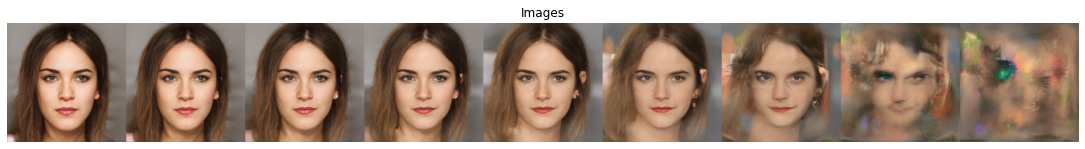

In [6]:
new_codes = source_image_code.repeat(9, axis=0).reshape(9, generator.net.num_layers, -1)
new_codes[:, layers, :] += boundary.reshape(1, 1, -1) * np.linspace(-3, 3, 9, dtype=np.float32).reshape(-1, 1, 1)
new_images = generator.easy_synthesize(new_codes, latent_space_type='wp')['image']

plt.figure(figsize=(19.2, 10.8))
plt.axis("off")
plt.title(f"Images")
plt.imshow(np.concatenate(new_images, axis=1))
plt.show()

In [136]:
steps = 100

new_codes = source_image_code.repeat(steps, axis=0).reshape(steps, generator.net.num_layers, -1)
new_codes[:, layers, :] += boundary.reshape(1, 1, -1) * np.linspace(-3, 2, steps, dtype=np.float32).reshape(-1, 1, 1)
new_images = generator.easy_synthesize(new_codes, latent_space_type='wp')['image']

import cv2 as cv

videowrite = cv.VideoWriter(rf'{source_image_name.split(".")[0]}_{attribute}.mp4', cv.VideoWriter_fourcc(*'XVID'), 20, (resolution, resolution))
for i in range(steps):
  b, g, r = new_images[i].transpose(2, 0, 1)
  image = np.array([r, g, b]).transpose(1, 2, 0)
  videowrite.write(image)
videowrite.release()

In [8]:
ATTRS = ['age', 'eyeglasses', 'gender', 'pose', 'expression']
boundaries = {}
for attr in ATTRS:
  boundary_path = os.path.join('./boundaries', 'stylegan_ffhq256', attr + '.npy')
  boundary_file = np.load(boundary_path, allow_pickle=True)[()]
  boundary = boundary_file['boundary']
  manipulate_layers = boundary_file['meta_data']['manipulate_layers']
  boundaries[attr] = []
  boundaries[attr].append(boundary)
  boundaries[attr].append(manipulate_layers)
  print(attr, manipulate_layers)

age [0, 1, 2, 3, 4, 5]
eyeglasses [0, 1, 2]
gender [2, 3, 4]
pose [0, 1, 2]
expression [2, 3, 4, 5]


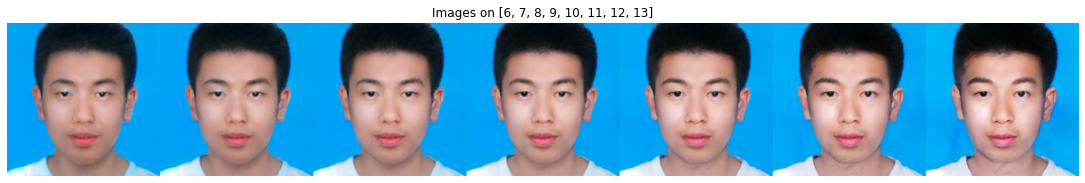

In [82]:
layer_low = 6 #@param {type:"slider", min:0, max:13, step:1}
layer_high = 13 #@param {type:"slider", min:0, max:13, step:1}
semantic = 4 #@param {type:"slider", min:1, max:10, step:1}

layers = list(range(layer_low, layer_high + 1))

weights = []
for layer in layers:
    weights.append(generator.net.synthesis.__getattr__(f'layer{layer}').epilogue.style_mod.dense.fc.weight.T.cpu().detach().numpy())
weight = np.concatenate(weights, axis=1).astype(np.float32)
weight = weight / np.linalg.norm(weight, axis=0, keepdims=True)
eigen_values, eigen_vectors = np.linalg.eig(weight.dot(weight.T))
boundaries = eigen_vectors.T
boundary = boundaries[semantic]

sematic_up = 4 #@param {type:"slider", min:0, max:5, step:0.1}
sematic_down = -4 #@param {type:"slider", min:-10, max:0, step:0.1}
steps = 7 #@param {type:"slider", min:2, max:12, step:1}

new_codes = source_image_code.repeat(steps, axis=0).reshape(steps, generator.net.num_layers, -1)
new_codes[:, layers, :] += boundary.reshape(1, 1, -1) * np.linspace(sematic_down, sematic_up, steps, dtype=np.float32).reshape(-1, 1, 1)
new_images = generator.easy_synthesize(new_codes, latent_space_type='wp')['image']

plt.figure(figsize=(19.2, 10.8))
plt.axis("off")
plt.title(f"Images on {layers}")
plt.imshow(np.concatenate(new_images, axis=1))
plt.show()

In [77]:
import cv2 as cv

def addManipulateImages(writer, layers, sematic, sematic_limits, duration=8):
  weights = []
  for layer in layers:
    weights.append(generator.net.synthesis.__getattr__(f'layer{layer}').epilogue.style_mod.dense.fc.weight.T.cpu().detach().numpy())
  weight = np.concatenate(weights, axis=1).astype(np.float32)
  weight = weight / np.linalg.norm(weight, axis=0, keepdims=True)
  eigen_values, eigen_vectors = np.linalg.eig(weight.dot(weight.T))
  boundaries = eigen_vectors.T
  boundary = boundaries[semantic]

  steps = int(duration / 2 * 24)
  linspace = np.r_[np.linspace(0, sematic_limits, steps, dtype=np.float32).reshape(-1, 1, 1),
             np.linspace(sematic_limits, 0, steps, dtype=np.float32).reshape(-1, 1, 1)]

  new_codes = source_image_code.repeat(steps * 2, axis=0).reshape(steps * 2, generator.net.num_layers, -1)
  new_codes[:, layers, :] += boundary.reshape(1, 1, -1) * linspace
  new_images = generator.easy_synthesize(new_codes, latent_space_type='wp')['image']

  for i in range(steps * 2):
    b, g, r = new_images[i].transpose(2, 0, 1)
    image = np.array([r, g, b]).transpose(1, 2, 0)
    writer.write(image)

def addInterpolateImages(writer, duration=8):
  steps = int(duration / 2 * 24)

  linspace = np.r_[np.linspace(0, 1, steps, dtype=np.float32).reshape(-1, 1, 1),
             np.linspace(1, 0, steps, dtype=np.float32).reshape(-1, 1, 1)]
  inter_codes = (1 - linspace) * source_image_code + linspace * target_image_code
  inter_images = generator.easy_synthesize(inter_codes, latent_space_type='wp')['image']

  for i in range(steps * 2):
    b, g, r = inter_images[i].transpose(2, 0, 1)
    image = np.array([r, g, b]).transpose(1, 2, 0)
    writer.write(image)


videowriter = cv.VideoWriter(rf'{source_image_name.split(".")[0]}.mp4', cv.VideoWriter_fourcc(*'XVID'), 24, (resolution, resolution))
addManipulateImages(videowriter, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], sematic=1, sematic_limits=2)
addManipulateImages(videowriter, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], sematic=1, sematic_limits=-4)
addManipulateImages(videowriter, [2, 3, 4], sematic=1, sematic_limits=4)
addManipulateImages(videowriter, [2, 3, 4], sematic=1, sematic_limits=-4)
addInterpolateImages(videowriter)
videowriter.release()

loss_pix: 0.009, loss_feat: 552.026, loss: 0.036: 100%|██████████| 100/100 [00:28<00:00,  3.52it/s]


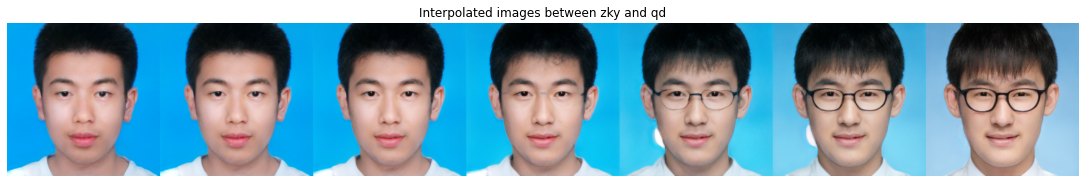

In [49]:
step = 7

source_image_name = 'zky.jpg'
target_image_name = 'qd.jpg'

source_image = align(source_image_name)
target_image = align(target_image_name)

source_image_code = inverter.easy_invert(source_image, 1)[0]
target_image_code = inverter.easy_invert(target_image, 1)[0]

linspace = np.linspace(0, 1, step).reshape(-1, 1, 1).astype(np.float32)
inter_codes = (1 - linspace) * source_image_code + linspace * target_image_code
inter_images = generator.easy_synthesize(inter_codes, latent_space_type='wp')['image']

plt.figure(figsize=(19.2, 10.8))
plt.axis("off")
plt.title(f"Interpolated images between {source_image_name.split('.')[0]} and {target_image_name.split('.')[0]}")
plt.imshow(np.concatenate(inter_images, axis=1))
plt.show()